In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from matplotlib.pyplot import plot, show

In [2]:
LABEL = 'label'

df_train = pd.read_csv('data/商品需求训练集.csv')
df_train_order = pd.read_csv('data/商品月订单训练集.csv')
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
#df_train = df_train.groupby(['product_id', 'year', 'month'])[['is_sale_day', 'label']].sum().reset_index()
df_train = df_train.merge(df_train_order, on=['product_id', 'year', 'month'], how='left')

df_test = pd.read_csv('data/商品需求测试集.csv')
df_test_order = pd.read_csv('data/商品月订单测试集.csv')
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['year'] = df_test['date'].dt.year
df_test['month'] = df_test['date'].dt.month
df_test['day'] = df_test['date'].dt.day

#df_test = df_test.groupby(['product_id', 'year', 'month'])[['is_sale_day']].sum().reset_index()
df_test = df_test.merge(df_test_order, on=['product_id', 'year', 'month'], how='left')

# feats = ['month', 'order', 'start_stock', 'end_stock']

df = pd.concat([df_train, df_test])

In [3]:
df = df.drop(['date'],axis=1)

In [4]:
df_train

,product_id,date,is_sale_day,label,year,month,day,type,order,start_stock,end_stock
0,1001,2018-02-01,0,274.0,2018,2,1,A1,1129.0,47.0,70.0
1,1001,2018-02-02,0,131.0,2018,2,2,A1,1129.0,47.0,70.0
2,1001,2018-02-03,0,0.0,2018,2,3,A1,1129.0,47.0,70.0
3,1001,2018-02-04,0,0.0,2018,2,4,A1,1129.0,47.0,70.0
4,1001,2018-02-05,0,0.0,2018,2,5,A1,1129.0,47.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...
221739,1210,2020-12-27,1,126.0,2020,12,27,A3,17381.0,88.0,90.0
221740,1210,2020-12-28,1,114.0,2020,12,28,A3,17381.0,88.0,90.0
221741,1210,2020-12-29,1,0.0,2020,12,29,A3,17381.0,88.0,90.0
221742,1210,2020-12-30,1,0.0,2020,12,30,A3,17381.0,88.0,90.0


In [5]:
for i in range(1, 8):
    for f in [LABEL, 'order', 'start_stock', 'end_stock']:
        df[f+'_shift_%d'%i] = df.groupby('product_id')[f].shift(i+3)

for i in range(4):
    for f in ['order', 'start_stock', 'end_stock']:
        df[f+'_shift_-%d'%i] = df.groupby('product_id')[f].shift(-i)

for i in [3, 6]:
    for f in [LABEL, 'order', 'start_stock', 'end_stock']:
        df[f+'_mean_%d'%i] = df[[f+'_shift_%d'%i for i in range(1, i+1)]].mean(axis=1)
        df[f+'_std_%d'%i] = df[[f+'_shift_%d'%i for i in range(1, i+1)]].std(axis=1)
        df[f+'_median_%d'%i] = df[[f+'_shift_%d'%i for i in range(1, i+1)]].median(axis=1)

le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])
df['type'] = df['type'].astype('category')

df['product_id'] = df['product_id'].astype('category')

df_train = df[df[LABEL].notna()].reset_index(drop=True)
df_test = df[df[LABEL].isna()].reset_index(drop=True)

feats = [f for f in df_test if f not in ['year', 'label']]

df_train[LABEL+'_log1p'] = np.log1p(df_train[LABEL])

----------- 0


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l2: 1.26437
Early stopping, best iteration is:
[1346]	valid_0's l2: 1.26122
----------- 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[847]	valid_0's l2: 1.27897
----------- 2
Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l2: 1.22487
Early stopping, best iteration is:
[1218]	valid_0's l2: 1.22081
----------- 3
Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l2: 1.24638
Early stopping, best iteration is:
[952]	valid_0's l2: 1.24588
----------- 4
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[737]	valid_0's l2: 1.26484
0.34611291170925823
2.4996706518950065


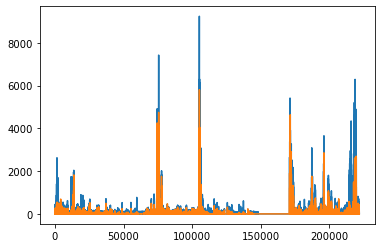

In [6]:
params = {
    'learning_rate': 0.05,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'verbose': -1,
    'seed': 2222,
    'n_jobs': -1,
}

fold_num = 5
seeds = [2222]
oof = np.zeros(len(df_train))
importance = 0
pred_y = pd.DataFrame()
for seed in seeds:
    kf = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=seed)
    for fold, (train_idx, val_idx) in enumerate(kf.split(df_train[feats], df_train['product_id'])):
        print('-----------', fold)
        train = lgb.Dataset(df_train.loc[train_idx, feats],
                            df_train.loc[train_idx, LABEL+'_log1p'])
        val = lgb.Dataset(df_train.loc[val_idx, feats],
                          df_train.loc[val_idx, LABEL+'_log1p'])
        model = lgb.train(params, train, valid_sets=[val], num_boost_round=10000,
                          callbacks=[lgb.early_stopping(100), lgb.log_evaluation(1000)])

        oof[val_idx] += model.predict(df_train.loc[val_idx, feats]) / len(seeds)
        pred_y['fold_%d_seed_%d' % (fold, seed)] = model.predict(df_test[feats])
        importance += model.feature_importance(importance_type='gain') / fold_num

df_train['target_weight'] = df_train[LABEL] / df_train.groupby(['year', 'month'])[LABEL].transform('sum')
df_train['oof'] = np.expm1(oof)
score1 = np.sum((1 - np.abs(df_train[LABEL]-df_train['oof']) / (df_train[LABEL])
                 ) *
                df_train['target_weight']) / 35
print(score1)
print(np.mean(np.abs(df_train[LABEL]-np.expm1(oof))/(df_train[LABEL]+1)))
plot(df_train[LABEL])
plot(np.expm1(oof))
show()


In [7]:
feats_importance = pd.DataFrame()
feats_importance['name'] = feats
feats_importance['importance'] = importance
print(feats_importance.sort_values('importance', ascending=False)[:30])
df_test[LABEL] = np.expm1(pred_y.mean(axis=1).values)

df_test = df_test.sort_values(by=['month', 'product_id'])
sub = pd.read_csv('data/提交示例.csv')
sub[LABEL] = df_test[LABEL].values
sub[LABEL] = sub[LABEL].map(lambda x: x if x >= 0 else 0)

sub.to_csv('data/baseline0621.csv', index=False)

                    name    importance
5            start_stock  1.641212e+06
39  start_stock_shift_-1  8.499858e+05
60           label_std_6  4.495475e+04
4                  order  3.318590e+04
7          label_shift_1  1.040503e+04
0             product_id  1.014532e+04
46    end_stock_shift_-3  9.698215e+03
44        order_shift_-3  8.106021e+03
41        order_shift_-2  6.832684e+03
40    end_stock_shift_-1  6.807261e+03
45  start_stock_shift_-3  6.000264e+03
47          label_mean_3  5.074401e+03
6              end_stock  5.070855e+03
3                   type  4.218423e+03
43    end_stock_shift_-2  3.912443e+03
42  start_stock_shift_-2  3.555947e+03
38        order_shift_-1  3.303485e+03
28         order_shift_6  2.750212e+03
63           order_std_6  2.676060e+03
56      end_stock_mean_3  2.549243e+03
32         order_shift_7  2.496305e+03
34     end_stock_shift_7  2.358053e+03
15         label_shift_3  2.239206e+03
16         order_shift_3  2.159150e+03
51           order_std_3 